## 0) Setup (imports)
**What we will do in this step**
- Import the libraries we need for data handling, plotting, and modeling.
- Set a random seed for reproducibility.


In [2]:
# Import pandas for working with tabular data (DataFrames), CSV files, grouping, filtering, etc.
import pandas as pd

# Import NumPy for numerical computing (arrays, math functions, random numbers, NaN handling, etc.)
import numpy as np

# Import Matplotlib's plotting interface (plt) for making charts/plots inside the notebook
import matplotlib.pyplot as plt


# Import Path to work with file paths in an OS-independent way (Windows/Mac/Linux friendly)
from pathlib import Path


# Import train_test_split to split data into training and testing sets (to evaluate fairly and avoid leakage)
from sklearn.model_selection import train_test_split

# Import ColumnTransformer to apply different preprocessing steps to different column groups
# (e.g., scale numeric columns but one-hot encode categorical columns)
from sklearn.compose import ColumnTransformer

# Import Pipeline to chain multiple steps (preprocessing + model) into one reusable workflow
# and to ensure we do "fit on TRAIN, transform on TEST" correctly
from sklearn.pipeline import Pipeline

# Import OneHotEncoder to convert categorical columns into numeric dummy/indicator variables
# Import StandardScaler to standardize numeric columns (mean=0, std=1), important for PCA and many models
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Import SimpleImputer to fill missing values (e.g., median for numeric, most_frequent for categorical)
from sklearn.impute import SimpleImputer

# Import PCA to perform Principal Components Analysis for dimensionality reduction on numeric features
from sklearn.decomposition import PCA


# Import LogisticRegression as a baseline classification model that can output probabilities
from sklearn.linear_model import LogisticRegression

# Import common evaluation tools for classification:
# - confusion_matrix: raw counts of TN/FP/FN/TP
# - ConfusionMatrixDisplay: convenient plot for the confusion matrix
# - accuracy, precision, recall, f1: standard metric menu
# - roc_curve and roc_auc_score: ROC curve and AUC for ranking performance across thresholds
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)


# Set a constant "random seed" value so results are reproducible (same split, same sampling, etc.)
RANDOM_STATE = 660

# Tell NumPy's random number generator to use this seed
# This helps ensure that any NumPy-based randomness is repeatable in future runs
np.random.seed(RANDOM_STATE)

## 1) Load the dataset
**What we will do in this step**
- Load the synthetic dataset.
- Quickly inspect rows/columns and basic column types.


In [34]:
csv_path = "shopping_behavior_v2_synthetic_500.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
display(df.head())
display(df.dtypes)


Shape: (500, 18)


,Customer ID,Age,Gender,Item Purchased,Category,Purchase Amount (USD),Location,Size,Color,Season,Review Rating,Subscription Status,Shipping Type,Discount Applied,Promo Code Used,Previous Purchases,Payment Method,Frequency of Purchases
0,1,19.0,Female,Sandals,Footwear,60.0,North Carolina,S,Pink,Summer,3.0,Yes,Free Shipping,No,No,45.0,PayPal,Annually
1,2,64.0,Female,Jeans,Clothing,17.0,Alabama,NaN,Blue,Summer,4.3,Yes,Standard,Yes,Yes,10.0,Apple Pay,Monthly
2,3,55.0,Male,Coat,Clothing,48.0,Louisiana,M,NaN,Fall,2.8,No,NaN,Yes,No,3.0,Bank Transfer,NaN
3,4,55.0,Female,Blouse,Clothing,53.0,New York,S,Yellow,NaN,4.9,Yes,Express,No,No,8.0,Debit Card,Weekly
4,5,NaN,Male,Coat,NaN,97.0,Washington,M,Yellow,Winter,4.4,Yes,NaN,Yes,Yes,23.0,PayPal,Quarterly


Customer ID                 int64
Age                       float64
Gender                     object
Item Purchased             object
Category                   object
Purchase Amount (USD)     float64
Location                   object
Size                       object
Color                      object
Season                     object
Review Rating             float64
Subscription Status        object
Shipping Type              object
Discount Applied           object
Promo Code Used            object
Previous Purchases        float64
Payment Method             object
Frequency of Purchases     object
dtype: object

## 2) Choose a target (binary classification)
**What we will do in this step**
- We need a **binary target**.
- We will use **Subscription Status** (Yes/No) as the target `y`.
- Then we will split into TRAIN and TEST **once**, and reuse the split for PCA + evaluation work.


In [36]:
# Name of the column we will predict (our target variable)
TARGET_COL = "Subscription Status"

# Make sure target is binary and convert to 0/1

# Convert the target column to strings so we can safely use string operations
# .str.strip() removes leading/trailing whitespace (e.g., " Yes " -> "Yes")
# .str.lower() converts text to lowercase (e.g., "YES" -> "yes") so mapping is consistent
# NOTE: Real missing values (NaN) become the literal string "nan" after astype(str)
df[TARGET_COL] = df[TARGET_COL].astype(str).str.strip().str.lower()

# Replace the standardized text labels with numeric labels used for modeling:
# "yes" -> 1, "no" -> 0
df[TARGET_COL] = df[TARGET_COL].replace({"yes": 1, "no": 0})

# If there are any unexpected values, show them

# df[TARGET_COL].isin([0, 1]) is True for valid target values (0 or 1) and False otherwise
# ~ flips True/False, so ~isin([0,1]) means "NOT 0 or 1" (invalid or missing-like values)
# .loc[..., TARGET_COL] selects the target values only for those invalid rows
# .unique() lists the distinct invalid values found (e.g., "nan" if there were missing targets)
bad_vals = df.loc[~df[TARGET_COL].isin([0, 1]), TARGET_COL].unique()

# Print the invalid values so we can see what (if anything) needs cleaning
print("Unexpected target values (should be empty):", bad_vals)

# Drop rows with missing/invalid target (if any)

# Keep only rows where the target is valid (0 or 1)
# .copy() creates an independent DataFrame to avoid chained-assignment issues later
df_model = df[df[TARGET_COL].isin([0, 1])].copy()

# Drop identifier column(s) that should not be used as predictors
df_model = df_model.drop(columns=["Customer ID"], errors="ignore")

# Create X (features) by dropping the target column from the cleaned modeling DataFrame
X = df_model.drop(columns=[TARGET_COL])

# Create y (target) as the cleaned target column, forcing it to integer type (0/1)
y = df_model[TARGET_COL].astype(int)

# Print and display the final class distribution after cleaning (how many 0s vs 1s)
print("Target distribution (0=no, 1=yes):")

# Count occurrences of each class (0 and 1) and format as a one-column DataFrame named "count"
display(y.value_counts().to_frame("count"))


Unexpected target values (should be empty): ['nan']
Target distribution (0=no, 1=yes):


,count
Subscription Status,
1,250
0,210


## Interpretation of the output

1) Unexpected target values (should be empty): ['nan']
* This means: after cleaning/mapping step, some rows still have a target value that is not 0 or 1.
* Specifically, the invalid value is the string 'nan'.
* Why is it 'nan' (a string) instead of a real NaN?
    * Because we did astype(str) first. When a true missing value NaN is converted to string, it becomes 'nan'.
    * So: our dataset contains missing values in Subscription Status, and they were detected correctly as “unexpected.”

2) Target distribution table
* 1: 250
* 0: 210

This is the distribution after dropping invalid/missing targets (we kept only rows where target is 0 or 1).
* Total usable rows for modeling: 250 + 210 = 460
* About 54.3% “Yes” (1) and 45.7% “No” (0).
* This is not severely imbalanced (it’s fairly close to balanced), so metrics like accuracy won’t be completely misleading due to extreme imbalance—but precision/recall and threshold tuning can still matter.

*If we want the cleanest way to keep NaNs as real NaNs (instead of 'nan'), we should avoid astype(str) and handle missing values first.*
*But for teaching purposes, our current code is fine because it clearly reveals “some targets are missing and we removed them.”*

## 3) Train/Test split (leakage-aware rule)
**What we will do in this step**
- Split the data into TRAIN and TEST.
- From here on:
  - **Fit** learned steps (imputation, scaling, PCA, model) on **TRAIN only**
  - **Transform / evaluate** on TEST


In [40]:
# Split the dataset into TRAIN and TEST sets so we can evaluate the model on unseen data
# X = feature matrix (all predictors), y = target vector (0/1)
X_train, X_test, y_train, y_test = train_test_split(
    X,                      # features to split
    y,                      # target to split (kept aligned with X)
    test_size=0.25,         # 25% of the data goes to TEST, 75% stays in TRAIN
    random_state=RANDOM_STATE,  # fixed seed so the split is reproducible every time
    stratify=y              # keeps the class proportions (0 vs 1) similar in TRAIN and TEST
)

# Print the shapes (rows, columns) to confirm how many samples went to TRAIN vs TEST
print("X_train:", X_train.shape, "X_test:", X_test.shape)

# Print a label so the next output is clear
print("y_train distribution:")

# Show the class distribution in TRAIN as proportions (not counts)
# value_counts(normalize=True) returns proportions instead of raw counts
# rename(...) gives the column a meaningful name
# to_frame() formats the result as a DataFrame for nicer display in Jupyter
display(
    y_train.value_counts(normalize=True)
          .rename("train_proportion")
          .to_frame()
)

X_train: (345, 16) X_test: (115, 16)
y_train distribution:


,train_proportion
Subscription Status,
1,0.542029
0,0.457971




### What PCA does
- PCA takes numeric features and creates new features called **principal components** (PC1, PC2, …).
- Each PC is a weighted combination of original numeric features.
- PCs are ordered by variance explained (information captured).

### Why PCA can help
- When predictors are high-dimensional and/or correlated (especially after encoding), PCA can reduce dimensionality.
- Trade-off: PCs are **harder to interpret** than original features.

### Leakage-aware rule
We fit PCA on **TRAIN only**, then transform TRAIN and TEST using what PCA learned from TRAIN.


## 4) Select numeric columns for PCA
**What we will do in this step**
- PCA is applied to **numeric features** (after imputation + scaling).
- Identify numeric columns in `X_train`.


In [44]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases']
Categorical columns: ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Payment Method', 'Frequency of Purchases']


## 5) Impute + scale numeric columns (TRAIN only)
**What we will do in this step**
- Missing values can break PCA.
- PCA is scale-sensitive, so we standardize numeric features.
- We fit the imputer/scaler on TRAIN, then transform TRAIN and TEST.


In [47]:
# Create a preprocessing pipeline for NUMERIC columns only.
# A Pipeline runs steps in order and helps prevent data leakage by fitting on TRAIN first.
num_pipe = Pipeline(steps=[
    # Step 1: Impute (fill) missing numeric values using the column median (computed from TRAIN during fit)
    ("imputer", SimpleImputer(strategy="median")),
    
    # Step 2: Standardize numeric features so each column has mean ~0 and std ~1 (based on TRAIN during fit)
    ("scaler", StandardScaler())
])

# Fit on TRAIN numeric only

# fit_transform does TWO things on TRAIN:
# 1) fit: learns the medians (for imputation) and means/std devs (for scaling) from TRAIN only
# 2) transform: applies those learned values to produce the cleaned + scaled TRAIN numeric matrix
X_train_num_scaled = num_pipe.fit_transform(X_train[num_cols])

# transform on TEST:
# Apply the SAME medians and scaling parameters learned from TRAIN to TEST numeric data
# (we do NOT fit on TEST, to avoid leakage)
X_test_num_scaled = num_pipe.transform(X_test[num_cols])

# Print a label so the next outputs are clear
print("After impute+scale:")

# Show the dimensions of the processed numeric matrices
print("X_train_num_scaled shape:", X_train_num_scaled.shape)
print("X_test_num_scaled shape:", X_test_num_scaled.shape)

# Check whether any NaN values remain after imputation/scaling in TRAIN
print("Any NaN left in TRAIN scaled?", np.isnan(X_train_num_scaled).any())

# Check whether any NaN values remain after imputation/scaling in TEST
print("Any NaN left in TEST scaled?", np.isnan(X_test_num_scaled).any())


After impute+scale:
X_train_num_scaled shape: (345, 4)
X_test_num_scaled shape: (115, 4)
Any NaN left in TRAIN scaled? False
Any NaN left in TEST scaled? False


## 6) Fit PCA on TRAIN (full PCA first)
**What we will do in this step**
- Fit PCA with `n_components=None` (compute all components).
- This lets us compute **variance explained** per component and cumulative.


In [50]:
pca_full = PCA(n_components=None, random_state=RANDOM_STATE)
pca_full.fit(X_train_num_scaled)

print("PCA fitted successfully on TRAIN.")
print("Number of components:", pca_full.n_components_)


PCA fitted successfully on TRAIN.
Number of components: 4


## 7) Variance explained (table + plot)
**What we will do in this step**
- Create a table of variance explained by each component.
- Plot cumulative variance to look for an “elbow” and make a practical choice of k.

**Variance is a way to measure how much values “spread out” or “vary”.**
* If a feature hardly changes (almost the same value for everyone), its variance is low.
* If a feature changes a lot across people (wide range of values), its variance is high.

**Example:**
* A column like “Age” in a group of mostly 20–22 year-olds → low variance.
* “Purchase Amount” ranging from $5 to $500 → high variance.

**Why variance matters in PCA**
PCA tries to find new axes (principal components) that capture the most variation in the data.

*Think of it like this:*
* Data points form a “cloud.”
* PCA looks for the direction where the cloud is longest (most spread out).
* That direction becomes PC1.
* Then it finds the next direction, perpendicular to PC1, that captures the next biggest spread → PC2, and so on.

**How “variance explained” helps us decide how many PCs to keep**
“Variance explained” tells us:
* How much of the original information/structure is still present if we keep only the first k components.
    * If PC1 explains 70%, we could keep just PC1 and still retain most of the data’s structure.
    * If PC1 explains 22% (like our output), that means no single direction summarizes the data well, so reducing dimensions loses information faster.

**Practical takeaway**
Variance explained is a data-driven way to choose how many components to keep:
* Keep more PCs → more information retained, but less reduction.
* Keep fewer PCs → simpler model / fewer dimensions, but more information lost.

*Variance is “how much the data varies,” and in PCA it becomes a scoreboard for how much information each component captures.*

,component,variance_explained,cumulative_variance
0,PC1,0.279635,0.279635
1,PC2,0.260334,0.539969
2,PC3,0.243334,0.783302
3,PC4,0.216698,1.000000


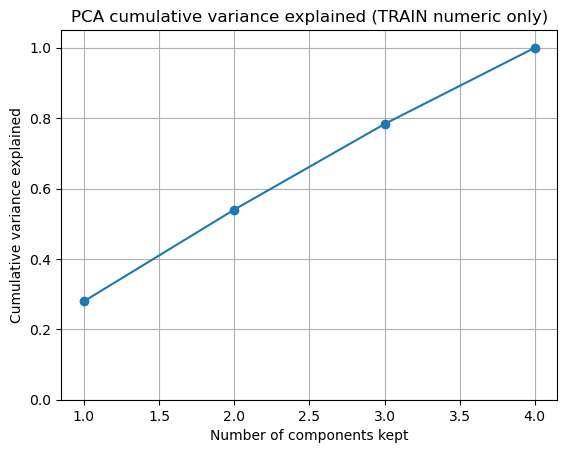

In [53]:
# pca_full.explained_variance_ratio_ gives the fraction of total variance explained by each principal component
# Example: if PC1 = 0.22, then PC1 alone explains about 22% of the variance in the scaled numeric data
var_ratio = pca_full.explained_variance_ratio_

# Compute the cumulative sum of the variance ratios
# This tells us how much total variance is explained when we keep the first k components
# Example: cum_var[2] = variance explained by PC1 + PC2 + PC3
cum_var = np.cumsum(var_ratio)

# Build a summary table with:
# - component names: PC1, PC2, ...
# - variance_explained: each component’s individual variance share
# - cumulative_variance: running total up to that component
pca_summary = pd.DataFrame({
    "component": [f"PC{i+1}" for i in range(len(var_ratio))],  # creates labels PC1..PC5
    "variance_explained": var_ratio,                           # individual variance explained per PC
    "cumulative_variance": cum_var                             # cumulative variance explained up to each PC
})

# Display the table in the notebook
display(pca_summary)

# Plot the cumulative variance explained vs number of components kept (k)
# x-axis: number of PCs kept (1..5)
# y-axis: cumulative variance explained (0..1)
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")

# Add a title to clarify what the plot represents
plt.title("PCA cumulative variance explained (TRAIN numeric only)")

# Label axes so the plot is interpretable
plt.xlabel("Number of components kept")
plt.ylabel("Cumulative variance explained")

# Set y-axis limits to show the full 0–1 range clearly (slightly above 1 for padding)
plt.ylim(0, 1.05)

# Add gridlines to make it easier to read values
plt.grid(True)

# Render the plot
plt.show()


## 8) Choose number of components (k) by a variance target
**What we will do in this step**
- Pick a target like **90% variance explained**.
- Find the smallest k that reaches the target.
- Discuss: Is that k “worth it” (does it meaningfully reduce dimensions)?


In [56]:
# Set the variance-explained target we want PCA to achieve (here: 90%)
target = 0.90

# cum_var is a cumulative variance array like [0.22, 0.44, 0.65, 0.83, 1.00]
# (cum_var >= target) creates a boolean array telling us where we first reach 90%
# np.argmax(...) returns the index of the FIRST True (first time we hit/exceed the target)
# + 1 converts the 0-based index into a human-friendly component count (PC1=1, PC2=2, ...)
k = int(np.argmax(cum_var >= target) + 1)

# Print the chosen k in a readable sentence (target is formatted as a percent)
print(f"To reach at least {target:.0%} variance explained, keep k = {k} components.")

# Print how many numeric columns we started with (the original numeric dimensionality)
print("Original numeric dimensions:", len(num_cols))

# Print how many dimensions remain after PCA (k components kept)
print("Reduced dimensions:", k)


To reach at least 90% variance explained, keep k = 4 components.
Original numeric dimensions: 4
Reduced dimensions: 4


## 9) Fit PCA with chosen k and transform TRAIN/TEST
**What we will do in this step**
- Fit PCA(k) on TRAIN numeric data.
- Transform TRAIN and TEST numeric data into k principal components.


In [59]:
pca_k = PCA(n_components=k, random_state=RANDOM_STATE)

X_train_pca = pca_k.fit_transform(X_train_num_scaled)
X_test_pca = pca_k.transform(X_test_num_scaled)

print("X_train_pca:", X_train_pca.shape)
print("X_test_pca:", X_test_pca.shape)


X_train_pca: (345, 4)
X_test_pca: (115, 4)


## 10) Interpret PCA loadings (what each PC is “made of”)
**What we will do in this step**
- Loadings show how much each original numeric feature contributes to each PC.
- This helps interpret PCs (even though interpretation is still harder than original features).


In [62]:
loadings = pd.DataFrame(
    pca_k.components_.T,
    index=num_cols,
    columns=[f"PC{i+1}" for i in range(pca_k.n_components_)]
)

display(loadings)


,PC1,PC2,PC3,PC4
Age,-0.704958,-0.079686,-0.256137,0.656565
Purchase Amount (USD),0.038466,-0.685596,0.690466,0.227454
Review Rating,-0.035968,0.723588,0.624078,0.292664
Previous Purchases,0.707291,-0.005340,-0.261106,0.656913


## 11) Baseline model mini-lab (pipeline + probabilities)
**What we will do in this step**
- Build a leakage-aware pipeline:
  - numeric: impute → scale
  - categorical: impute → one-hot encode
  - model: logistic regression
- Fit on TRAIN, then generate predicted probabilities on TEST.


In **Step 11 (Baseline model mini-lab)** we’re building a **simple “first model”** so we can practice evaluation methods in the next steps.

Here’s what we’re doing:

* **We split the predictors into two groups:**

  * **Numeric columns** (like age, purchase amount, ratings, etc.)
  * **Categorical columns** (like gender, category, season, payment method, etc.)

* **We clean and prepare each group in the right way:**

  * For **numeric columns**:

    * Fill in missing numbers using the **median**
    * **Standardize** them so they’re on a comparable scale (mean 0, std 1)
  * For **categorical columns**:

    * Fill in missing categories using the **most common value**
    * Convert categories into numbers using **one-hot encoding** (turns categories into 0/1 indicator columns)

* **We bundle all of this into one “pipeline”:**

  * The pipeline ensures we always do preprocessing + modeling in the correct order
  * And it prevents **data leakage** because it learns preprocessing settings from **TRAIN only**, then applies them to TEST

* **We fit a baseline classifier (logistic regression):**

  * This is a standard, interpretable starting model for binary outcomes

* **We generate predicted probabilities on the TEST set:**

  * Instead of just predicting “Yes/No,” the model gives a **probability** like 0.78 (78% chance of “Yes”)
  * Those probabilities are what we’ll use next to:

    * choose thresholds (0.30, 0.50, 0.70…)
    * compute confusion matrices and metrics
    * draw ROC curves and calculate AUC
    * build lift/gains tables

So: **Step 11 sets up a clean, leakage-aware baseline model and produces probabilities—the raw material for all the evaluation work on Wednesday.**


In [67]:
# Use the list of numeric columns we identified earlier
numeric_features = num_cols

# Use the list of categorical (non-numeric) columns we identified earlier
categorical_features = cat_cols

# Build a preprocessing pipeline for numeric columns:
# 1) impute missing numeric values using the median (learned from TRAIN)
# 2) scale numeric values to mean=0 and std=1 (learned from TRAIN)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Build a preprocessing pipeline for categorical columns:
# 1) impute missing categorical values using the most frequent category (learned from TRAIN)
# 2) one-hot encode categories into dummy/indicator columns
#    handle_unknown="ignore" prevents errors if TEST contains a category not seen in TRAIN
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine both pipelines into one preprocessing step:
# - apply numeric_transformer to numeric_features
# - apply categorical_transformer to categorical_features
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# Define the baseline classifier:
# Logistic Regression is a common baseline for binary classification.
# max_iter=2000 gives it enough iterations to converge.
# random_state makes results reproducible (when the solver uses randomness).
clf = LogisticRegression(max_iter=2000, random_state=RANDOM_STATE)

# Build the full end-to-end pipeline:
# Step 1: preprocess (impute/scale numeric + impute/one-hot categorical)
# Step 2: clf (logistic regression model)
model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", clf)
])

# Fit the entire pipeline on TRAIN:
# - preprocessing steps learn parameters from TRAIN only (medians, means/stds, category levels)
# - logistic regression learns model coefficients from TRAIN only
model.fit(X_train, y_train)

# Probabilities for class 1

# predict_proba returns two columns for binary classification:
# - column 0: P(class=0)
# - column 1: P(class=1)
# [:, 1] extracts the probability of class 1 ("Yes" / Subscription Status = 1)
y_proba_test = model.predict_proba(X_test)[:, 1]

# Print a label for clarity
print("Predicted probability preview (TEST):")

# Display the first 10 predicted probabilities for TEST cases
display(pd.Series(y_proba_test).head(10))


Predicted probability preview (TEST):


0    0.422077
1    0.604627
2    0.788323
3    0.351660
4    0.316361
5    0.592391
6    0.618333
7    0.765853
8    0.442851
9    0.516713
dtype: float64

## 12) Confusion matrix (default threshold = 0.50)
**What we will do in this step**
- Convert probabilities to class predictions with a threshold of 0.50.
- Compute confusion matrix and common metrics.
- Discuss why one metric alone can be misleading.

* We already have **predicted probabilities** from the model (e.g., 0.78 means “78% chance the class is 1”).
* To turn probabilities into a **yes/no prediction**, we choose a **threshold**:

  * If probability **≥ 0.50**, predict **1**
  * If probability **< 0.50**, predict **0**
* Then we compare those predictions to the true labels on the **TEST** set by building a **confusion matrix** (counts of correct/incorrect predictions).
* Finally, we compute common metrics (accuracy, precision, recall, F1) and discuss why **looking at only one** can be misleading.

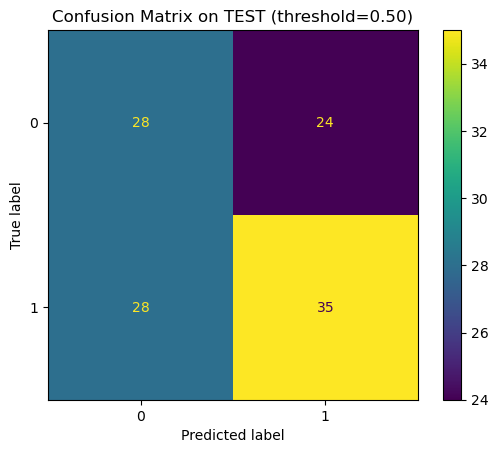

,metric,value
0,accuracy,0.547826
1,precision,0.593220
2,recall,0.555556
3,f1,0.573770


In [29]:
# Set the probability cutoff (threshold) for predicting class 1
threshold = 0.50

# Convert probabilities into class predictions:
# - if predicted probability >= 0.50 → predict 1
# - otherwise → predict 0
# .astype(int) converts True/False into 1/0
y_pred_test = (y_proba_test >= threshold).astype(int)

# Compute the confusion matrix comparing true labels (y_test) vs predicted labels (y_pred_test)
cm = confusion_matrix(y_test, y_pred_test)

# Create a display object to visualize the confusion matrix nicely
# display_labels=[0,1] labels the axes with the class names (0 and 1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot the confusion matrix
disp.plot()

# Add a title to clarify this is TEST performance at threshold=0.50
plt.title("Confusion Matrix on TEST (threshold=0.50)")

# Show the plot
plt.show()

# Compute accuracy: overall fraction of correct predictions
acc = accuracy_score(y_test, y_pred_test)

# Compute precision: among predicted 1s, how many were truly 1
# zero_division=0 avoids errors if the model predicts no 1s
prec = precision_score(y_test, y_pred_test, zero_division=0)

# Compute recall: among truly 1s, how many did we correctly catch as 1
rec = recall_score(y_test, y_pred_test, zero_division=0)

# Compute F1: a single score that balances precision and recall
f1 = f1_score(y_test, y_pred_test, zero_division=0)

# Put the metrics into a neat DataFrame for display
metrics_tbl = pd.DataFrame({
    "metric": ["accuracy", "precision", "recall", "f1"],
    "value": [acc, prec, rec, f1]
})

# Display the metrics table
display(metrics_tbl)


## 13) Threshold menu: how errors move when we change the cutoff
**What we will do in this step**
- Try multiple thresholds.
- For each threshold, compute FP, FN (and metrics).
- Observe the trade-offs (precision vs recall, FP vs FN).

We’re showing that the model doesn’t magically produce one fixed “Yes/No” answer.
It produces **probabilities**, and we get to choose the **threshold** that turns those probabilities into class predictions.

* A **lower threshold** (like 0.30) predicts **more 1s** → catches more true 1s (higher recall) but also creates more false alarms (higher FP).
* A **higher threshold** (like 0.70) predicts **fewer 1s** → fewer false alarms (lower FP) but misses many true 1s (higher FN).

This step helps us *see the trade-off* between:

* **Precision vs. recall**
* **False positives (FP) vs. false negatives (FN)**

In [31]:
# Define a helper function that computes confusion-matrix counts and metrics at a given threshold
def summarize_at_threshold(y_true, y_proba, thr):
    # Convert probabilities into predicted classes using the given threshold thr
    # If probability >= thr -> predict 1, else predict 0
    y_pred = (y_proba >= thr).astype(int)
    
    # Build the confusion matrix and unpack it into TN, FP, FN, TP
    # .ravel() flattens the 2x2 matrix into a 1D array of four values
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Return a dictionary of counts + metrics so we can build a clean summary table
    return {
        "threshold": thr,  # the cutoff we used
        "TP": tp, "FP": fp, "TN": tn, "FN": fn,  # confusion matrix counts
        "accuracy": accuracy_score(y_true, y_pred),  # overall correctness
        "precision": precision_score(y_true, y_pred, zero_division=0),  # correctness among predicted 1s
        "recall": recall_score(y_true, y_pred, zero_division=0),  # how many true 1s we captured
        "f1": f1_score(y_true, y_pred, zero_division=0),  # balance of precision and recall
    }

# Choose three thresholds to compare (low, default, high)
thresholds = [0.30, 0.50, 0.70]

# For each threshold, compute the summary using the helper function
rows = [summarize_at_threshold(y_test, y_proba_test, t) for t in thresholds]

# Convert results into a DataFrame and display it nicely
display(pd.DataFrame(rows))


,threshold,TP,FP,TN,FN,accuracy,precision,recall,f1
0,0.3,50,42,10,13,0.521739,0.543478,0.793651,0.645161
1,0.5,35,24,28,28,0.547826,0.593220,0.555556,0.573770
2,0.7,12,13,39,51,0.443478,0.480000,0.190476,0.272727


## 14) Cost-based cutoff (simple example)
**What we will do in this step**
- Assign a cost to FP and FN (example values).
- Compute the **total cost** under different thresholds.
- Choose the threshold with the lowest cost (given the cost assumptions).

Up to now, we treated **all mistakes the same**. But in real life, some mistakes are worse than others.

So here we:

* Assign a **cost** to each type of mistake:

  * **False Positive (FP)** cost = 1
  * **False Negative (FN)** cost = 5  (meaning: missing a true “1” is 5× worse than a false alarm)
* Try many thresholds (0.05, 0.10, 0.15, …, 0.95)
* For each threshold, count FP and FN and compute:

Total Cost = (FP×COST_FP)+(FN×COST_FN)

* Choose the threshold with the **lowest total cost**.

In [33]:
# Example costs (edit these for discussion)

# Cost of a False Positive (predict 1 when the true class is 0)
COST_FP = 1

# Cost of a False Negative (predict 0 when the true class is 1)
COST_FN = 5

# Define a helper function to compute total cost at a given threshold
def cost_at_threshold(y_true, y_proba, thr, cost_fp=1, cost_fn=5):
    # Convert probabilities into predicted classes using the threshold thr
    y_pred = (y_proba >= thr).astype(int)
    
    # Compute confusion matrix and unpack counts into TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Compute the total cost using the cost assumptions:
    # FP mistakes cost cost_fp each, FN mistakes cost cost_fn each
    total_cost = fp * cost_fp + fn * cost_fn
    
    # Return threshold, number of FP, number of FN, and the total cost
    return thr, fp, fn, total_cost

# Create a grid of thresholds from 0.05 to 0.95 (19 values)
# np.linspace(...) makes evenly spaced values; np.round(...,2) rounds to 2 decimals
grid = np.round(np.linspace(0.05, 0.95, 19), 2)

# Initialize an empty list to store results for each threshold
cost_rows = []

# Loop over each threshold in the grid
for thr in grid:
    # Compute FP, FN, and total cost at this threshold
    thr, fp, fn, total_cost = cost_at_threshold(y_test, y_proba_test, thr, COST_FP, COST_FN)
    
    # Store the results as a dictionary (one row for the final table)
    cost_rows.append({"threshold": thr, "FP": fp, "FN": fn, "total_cost": total_cost})

# Convert the list of dictionaries to a DataFrame, sort by total_cost (ascending),
# and reset the index so the best (lowest cost) row is at index 0
cost_df = pd.DataFrame(cost_rows).sort_values("total_cost").reset_index(drop=True)

# Display the best 10 thresholds by total cost
display(cost_df.head(10))

# Extract the threshold in the first row (lowest cost) as the "best" threshold
best_thr = cost_df.loc[0, "threshold"]

# Print the best threshold based on our cost assumptions
print("Best threshold by cost (given assumptions):", best_thr)


,threshold,FP,FN,total_cost
0,0.05,52,0,52
1,0.10,50,1,55
2,0.15,49,3,64
3,0.20,47,8,87
4,0.25,44,10,94
5,0.30,42,13,107
6,0.35,40,16,120
7,0.40,33,19,128
8,0.45,29,23,144
9,0.50,24,28,164


Best threshold by cost (given assumptions): 0.05


## 15) Visualize cost vs threshold
**What we will do in this step**
- Plot total cost across thresholds to see the “sweet spot”.

In Step 14, we calculated **total cost** at many thresholds.
In Step 15, we **plot those costs** so we can *see* how the threshold choice affects cost and where the “best” (lowest-cost) region is.

* **x-axis:** threshold (the cutoff for predicting class 1)
* **y-axis:** total cost on the TEST set (FP×cost + FN×cost)
* The “sweet spot” is where the curve is **lowest**.

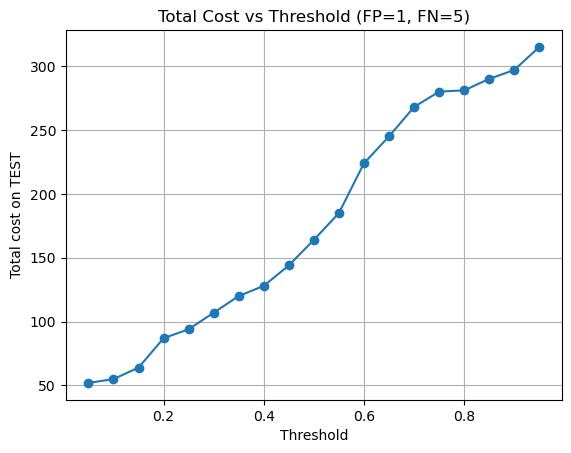

In [35]:
# Plot total cost (y-axis) against threshold values (x-axis)
# marker="o" puts a dot on each threshold so we can see individual grid points clearly
plt.plot(cost_df["threshold"], cost_df["total_cost"], marker="o")

# Add a title that also shows the FP and FN costs used in the calculation
plt.title(f"Total Cost vs Threshold (FP={COST_FP}, FN={COST_FN})")

# Label the x-axis as the threshold cutoff used to convert probabilities into class labels
plt.xlabel("Threshold")

# Label the y-axis as the total misclassification cost computed on the TEST set
plt.ylabel("Total cost on TEST")

# Add grid lines to make it easier to visually compare costs across thresholds
plt.grid(True)

# Display the plot
plt.show()


## 16) ROC curve and AUC (ranking-focused)
**What we will do in this step**
- ROC curve shows TPR vs FPR across all thresholds.
- AUC summarizes ranking performance (higher is better, 0.5 ≈ random).

In earlier steps, we picked a **single threshold** (like 0.50) and evaluated the model.
But the ROC curve answers a different question:

> “If we try **all possible thresholds**, how well can the model separate 1s from 0s overall?”

* The **ROC curve** shows the trade-off between:

  * **TPR (True Positive Rate)** = **recall** = how many real 1s we catch
  * **FPR (False Positive Rate)** = how many real 0s we incorrectly flag as 1
* The **AUC (Area Under the Curve)** is a single number summary of how well the model **ranks** positives higher than negatives.

  * **0.5** ≈ random guessing
  * **1.0** = perfect ranking

So ROC/AUC is “threshold-free” evaluation: it focuses on ranking quality, not one cutoff.

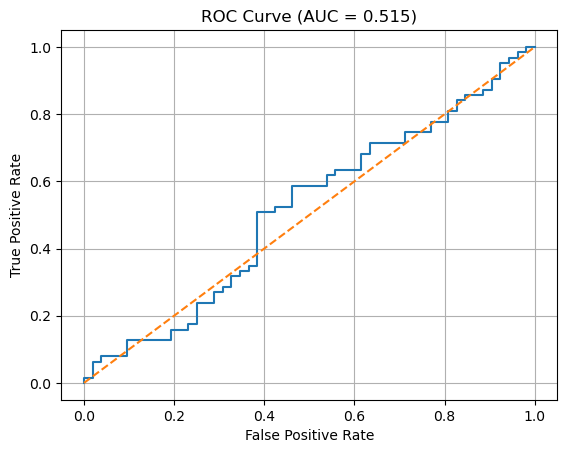

AUC: 0.5152625152625153


In [37]:
# Compute the ROC curve:
# fpr = false positive rate values across thresholds
# tpr = true positive rate values across thresholds (same as recall at each threshold)
# thr = the threshold values that produce each (fpr, tpr) point
fpr, tpr, thr = roc_curve(y_test, y_proba_test)

# Compute AUC (area under the ROC curve), a single-number summary of ranking performance
auc = roc_auc_score(y_test, y_proba_test)

# Plot the ROC curve line: FPR on x-axis, TPR on y-axis
plt.plot(fpr, tpr)

# Plot the diagonal reference line (random classifier baseline)
# If our ROC curve is close to this line, our model is close to random
plt.plot([0, 1], [0, 1], linestyle="--")

# Add a title that includes the AUC rounded to 3 decimals
plt.title(f"ROC Curve (AUC = {auc:.3f})")

# Label axes so we know what the plot shows
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Add grid lines for readability
plt.grid(True)

# Display the plot
plt.show()

# Print the exact AUC value
print("AUC:", auc)


## 17) Lift (and cumulative gains) — another ranking-focused view
**What we will do in this step**
- Sort cases by predicted probability (highest risk first).
- Compute cumulative gains and lift by deciles.
- Interpretation: “If we can only act on the top X%, how many positives do we capture?”

This step evaluates the model as a **ranking tool** instead of a “pick one threshold” classifier.

Imagine we can only take action on a limited number of customers (because of time/budget), like:

* call the **top 10%** most likely subscribers,
* or target the **top 30%** with a campaign.

So we:

1. **Sort** all TEST cases by predicted probability (highest first).
2. Split them into **10 equal-sized groups (deciles)**.
3. For each decile, count how many actual positives (1s) are inside.
4. Compute:

   * **Cumulative gains**: “If we contact the top X%, what % of all positives did we capture?”
   * **Lift**: “How much better is this decile than random selection?”

,decile,n,positives,avg_proba,cum_positives,cum_n,cum_capture_rate,lift
0,1,12,7,0.897878,7,12,0.111111,1.064815
1,2,11,4,0.770030,11,23,0.174603,0.663781
2,3,12,7,0.670844,18,35,0.285714,1.064815
3,4,11,8,0.603458,26,46,0.412698,1.327561
4,5,12,8,0.539395,34,58,0.539683,1.216931
5,6,11,6,0.472759,40,69,0.634921,0.995671
6,7,11,5,0.413404,45,80,0.714286,0.829726
7,8,12,5,0.348980,50,92,0.793651,0.760582
8,9,11,6,0.245524,56,103,0.888889,0.995671
9,10,12,7,0.133047,63,115,1.000000,1.064815


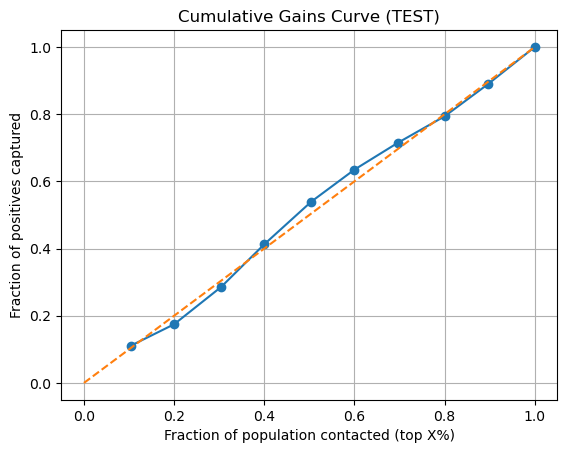

Baseline positive rate: 0.548


In [39]:
# Build a table with true labels and probabilities

# Create a DataFrame with:
# - y_true: the actual true class (0/1) for each TEST row
# - proba: the model’s predicted probability for class 1 on TEST
eval_tbl = pd.DataFrame({
    "y_true": y_test.values,
    "proba": y_proba_test
})

# Sort rows so the highest predicted probabilities come first (best-ranked / “highest risk” first)
# reset_index(drop=True) makes the index go 0,1,2,... after sorting
eval_tbl = eval_tbl.sort_values("proba", ascending=False).reset_index(drop=True)

# Add deciles (10 groups)

# Split the ranked rows into 10 equal-sized buckets based on row index (top 10%, next 10%, etc.)
# pd.qcut creates 10 groups; labels=False returns 0..9; +1 makes them 1..10
eval_tbl["decile"] = pd.qcut(eval_tbl.index, 10, labels=False) + 1

# Baseline positive rate

# Compute the overall positive rate in TEST (proportion of y_true==1)
# This is what we'd get “on average” if we selected cases at random
base_rate = eval_tbl["y_true"].mean()

# Gains/lift by decile

# Group by decile and compute summary stats:
# - n: number of records in the decile
# - positives: number of true positives (sum of 1s) in that decile
# - avg_proba: average predicted probability in that decile
by_decile = eval_tbl.groupby("decile").agg(
    n=("y_true", "size"),
    positives=("y_true", "sum"),
    avg_proba=("proba", "mean")
).reset_index()

# Compute cumulative totals as we move from decile 1 (top) down to decile 10 (bottom)

# Running total of positives captured if we take the top deciles up to this point
by_decile["cum_positives"] = by_decile["positives"].cumsum()

# Running total of people contacted (records) if we take the top deciles up to this point
by_decile["cum_n"] = by_decile["n"].cumsum()

# Cumulative capture rate:
# fraction of ALL positives in TEST that have been captured by contacting the top cum_n records
by_decile["cum_capture_rate"] = by_decile["cum_positives"] / eval_tbl["y_true"].sum()

# Lift for each decile:
# (positive rate in this decile) / (overall positive rate)
# If lift > 1, the decile is better than random; if lift < 1, worse than random
by_decile["lift"] = (by_decile["positives"] / by_decile["n"]) / base_rate

# Display the decile table
display(by_decile)

# Plot cumulative capture rate (gains curve)

# x-axis: fraction of population contacted so far (cum_n / total)
# y-axis: fraction of positives captured so far (cum_capture_rate)
plt.plot(by_decile["cum_n"] / len(eval_tbl), by_decile["cum_capture_rate"], marker="o")

# Plot the diagonal baseline: what we’d get with random selection
plt.plot([0, 1], [0, 1], linestyle="--")

# Add chart title and axis labels
plt.title("Cumulative Gains Curve (TEST)")
plt.xlabel("Fraction of population contacted (top X%)")
plt.ylabel("Fraction of positives captured")

# Add grid and show the plot
plt.grid(True)
plt.show()

# Print the baseline positive rate (overall proportion of class 1 in TEST)
print("Baseline positive rate:", round(base_rate, 3))


## 18) Oversampling (intro + optional code)
**What we will do in this step**
- Check whether the target is imbalanced.
- (Optional) Oversample the minority class in TRAIN to balance the classes.
- Important: Oversampling is done **only on TRAIN**, never on TEST.

Before we try techniques like oversampling, we first check whether the dataset is **imbalanced**.

* If one class is much rarer than the other (e.g., 95% vs 5%), many models will “favor” the majority class.
* Oversampling is one way to address this: we **increase the minority class** in the TRAIN set by duplicating/bootstrapping minority examples until the classes are more balanced.
* We **never oversample the TEST set**, because TEST must represent “real-world” data for an honest evaluation.

In [41]:
# Count how many 0s and 1s are in the TRAIN target vector
train_counts = y_train.value_counts()

# Print a label so the output is clear
print("TRAIN class counts:")

# Display the counts as a one-column table called "count"
display(train_counts.to_frame("count"))

# Compute an imbalance ratio:
# minority count / majority count
# - train_counts.min() is the smaller class count (minority)
# - train_counts.max() is the larger class count (majority)
imbalance_ratio = train_counts.min() / train_counts.max()

# Print the ratio (rounded) to quickly judge how imbalanced the data is
print("Minority/Majority ratio:", round(imbalance_ratio, 3))


TRAIN class counts:


,count
Subscription Status,
1,187
0,158


Minority/Majority ratio: 0.845


### Optional: simple random oversampling (if we want to demo it)
Below is a plain-Pandas oversampling approach (no extra packages).  
We oversample the minority class in **TRAIN**, then fit the same pipeline again.


In [43]:
from sklearn.utils import resample

# Combine X_train and y_train for resampling
train_df = X_train.copy()
train_df["_y"] = y_train.values

majority = train_df[train_df["_y"] == train_counts.idxmax()]
minority = train_df[train_df["_y"] == train_counts.idxmin()]

# Oversample minority to match majority size
minority_upsampled = resample(
    minority,
    replace=True,
    n_samples=len(majority),
    random_state=RANDOM_STATE
)

train_bal = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=RANDOM_STATE)

X_train_bal = train_bal.drop(columns=["_y"])
y_train_bal = train_bal["_y"].astype(int)

print("Balanced TRAIN distribution:")
display(y_train_bal.value_counts().to_frame("count"))

# Refit model on balanced TRAIN
model_bal = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])
model_bal.fit(X_train_bal, y_train_bal)

y_proba_test_bal = model_bal.predict_proba(X_test)[:, 1]
auc_bal = roc_auc_score(y_test, y_proba_test_bal)

print("AUC (original TRAIN):", round(auc, 3))
print("AUC (oversampled TRAIN):", round(auc_bal, 3))


Balanced TRAIN distribution:


,count
_y,
1,187
0,187


AUC (original TRAIN): 0.515
AUC (oversampled TRAIN): 0.491
